# Adversarial Search: Playing Dots and Boxes


## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play the game Dots and Boxes:

> "Dots and Boxes is a pencil-and-paper game for two players. The game starts with an empty grid of dots. Usually two players take turns adding a single horizontal or vertical line between two unjoined adjacent dots. A player who completes the fourth side of a 1x1 box earns one point and takes another turn. A point is typically recorded by placing a mark that identifies the player in the box, such as an initial. The game ends when no more lines can be placed. The winner is the player with the most points. The board may be of any size grid." (see [Dots and Boxes on Wikipedia](https://en.wikipedia.org/wiki/Dots_and_Boxes))

You can play Dots and Boxes [here](https://www.math.ucla.edu/~tom/Games/dots&boxes.html).

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

In [487]:
# Your code/answer goes here.

How big is the state space? Give an estimate and explain it.

In [488]:
# Your code/ answer goes here.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [489]:
# Your code/ answer goes here.

## Task 2: Game Environment and Random Agent [30 point]

You need to think about a data structure to represent the board meaning he placed lines and who finished what box. There are many options. Let's represent the board using a simple dictionary where `n` and `m` represents the number of dots horizontaly and vertically, respectively. Everybody needs to use the same representation so we can let agents play against each other later. 

In [490]:
# board = {
#     'n': 4,  ### hoizontal dots
#     'm': 4   ### vertical dots
# }

def draw_line(board, orientation, row, col):
    """
    Place a line on an exiting board.
       
    Parameters
    ----------
    board: dict
        the board
    orientation: str
        either 'h' or 'v' for horizontal or vertical
    row, col: int
        index of the starting dot for the line (starting with 0)
    
    """
    
    if orientation not in ['h', 'v']:
        return False
        
    if row < 0 or col < 0:
        return False
        
    if row >= board['n'] + (orientation == 'v') or col >= board['m'] + (orientation == 'h'):
        return False
        
    if (orientation, row, col) in board:
        return False
            
    board[(orientation, row, col)] = True
    return True
    





Write code to display the board. **Bonus point: Post your visualization code with an example output to the discussion board. The best visualization will earn you bonus participation points in this class.**

In [491]:
# Your code/ answer goes here.
#https://stackoverflow.com/questions/35109590/how-to-graph-nodes-on-a-grid-in-networkx
import matplotlib.pyplot as plt
import networkx as nx
edge_colors = ['blue', 'red']
edgeLabels = {}
def drawBoard(G):
    colors = nx.get_edge_attributes(G,'color').values()
    labels = nx.get_edge_attributes(G,'label').values()
    pos = {(x,y):(y,-x) for x,y in G.nodes()}
    nx.draw(G, pos=pos,
        node_color='lightgreen',
        edge_color=colors,
        width=8,
        with_labels=True,
        node_size=600)
    nx.draw_networkx_edge_labels(G, pos, edgeLabels)

def createsBox():
    return True

def createEmptyBoard(G):
    plt.figure(figsize=(6,6))
    for edge in G.edges():
        G.remove_edge(*edge)
    # Set margins for the axes so that nodes aren't clipped
    drawBoard(G)

def addEdge(G,board, x,y, orientation,player):
    color=edge_colors[player]


    if createsBox():
        label=player
    draw_line(board, orientation, x,y)
    if orientation == 'h':
        G.add_edge((x,y), (x,y+1), color=color, label=label)
        edgeLabels.update({((x,y),(x,y+1)):player})
    else:
        G.add_edge((x,y), (x+1,y), color=color, label=label)
        edgeLabels.update({((x,y),(x+1,y)):player})
    drawBoard(G)
    return board

# G = nx.grid_2d_graph(board['n'], board['m'])
# createEmptyBoard(G)
# addEdge(G, 0,0, 'h',0)
# addEdge(G, 0,0, 'v',1)
#
#
# addEdge(G, 0,1, 'v',1)
# addEdge(G, 1,0, 'h',0)
#
# addEdge(G,2,2, 'h',0)
# addEdge(G,2,2, 'v',1)
# addEdge(G,2,3, 'v',1)
# addEdge(G,3,2, 'h',0)
# print(board)


Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows as stored in the board).

In [522]:
# Your code/ answer goes here.
def result(board, draw_line):
    return board



def utility(board):
    #check who has more boxes and award that player a point
    player1=0
    player0=0
    #print(board)
    for i in range(board['n']-1):
        for j in range(board['m']-1):
            if (('h', i, j) in board and board['h',i,j]==True)\
                    and (('h', i+1, j) in board and board['h',i+1,j]==True) \
                    and (('v', i, j) in board and board['v',i,j]==True)\
                    and (('v', i, j+1) in board and board['v',i,j+1]==True):
                print("BOX FOUND")
                mostRecentMove = list(board.keys()).index(('h', i, j))
                if(list(board.keys()).index(('h', i+1, j)) > mostRecentMove):
                    mostRecentMove= list(board.keys()).index(('h', i+1, j))
                if(list(board.keys()).index(('v', i, j+1)) > mostRecentMove):
                    mostRecentMove= list(board.keys()).index(('v', i, j+1))
                if(list(board.keys()).index(('v', i, j)) > mostRecentMove):
                    mostRecentMove= list(board.keys()).index(('v', i, j))

                value_at_index=list(board.keys())[mostRecentMove]
                if(value_at_index[0]=='h'):
                    player = (edgeLabels[(value_at_index[1],value_at_index[2]),(value_at_index[1],value_at_index[2]+1)])
                    print("Box belongs to player ",player)
                if(value_at_index[0]=='v'):
                    player = (edgeLabels[(value_at_index[1],value_at_index[2]),(value_at_index[1]+1,value_at_index[2])])
                    print("Box belongs to player ",player)
                if(player==1):
                    player1+=1
                else:
                    player0+=1
    if player1>player0:
        print("Player 1 wins")
    elif player0>player1:
        print("Player 0 wins")
    else:
        print("Tie")
def actions(board):
    acts=[]
    #check if there are any available actions
    for i in range (board['n']-1):
        for j in range (board['m']-1):
            orientation = 'h'
            if (orientation, i, j) not in board:
                acts.append((orientation, i, j))
            orientation = 'v'
            if (orientation, i, j) not in board:
                acts.append((orientation, i, j))

    #n is horizontal dots, m is vertical dots
    for i in range(board['n']-1):
        if("v",i,board['m']-1) not in board:
            acts.append(("v",i,board['m']-1))
    for i in range(board['m']-1):
        if("h",board['n']-1,i) not in board:
            acts.append(("h",board['n']-1,i))
    return acts


def terminal(board):
    if actions(board)==[]:
        return True
    else:
        return False

#print(actions(board))



#utility(board)

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on bt yhe environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

BOX FOUND
Box belongs to player  0
BOX FOUND
Box belongs to player  1
BOX FOUND
Box belongs to player  1
BOX FOUND
Box belongs to player  0
BOX FOUND
Box belongs to player  0
BOX FOUND
Box belongs to player  1
BOX FOUND
Box belongs to player  1
BOX FOUND
Box belongs to player  1
BOX FOUND
Box belongs to player  1
BOX FOUND
Box belongs to player  1
BOX FOUND
Box belongs to player  1
BOX FOUND
Box belongs to player  1
BOX FOUND
Box belongs to player  0
BOX FOUND
Box belongs to player  0
BOX FOUND
Box belongs to player  1
BOX FOUND
Box belongs to player  0
Player 1 wins


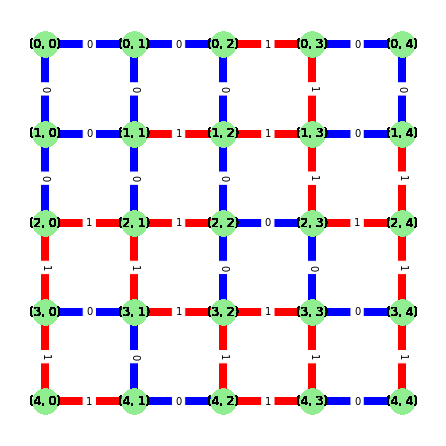

In [528]:
# Your code/ answer goes here.
import random

def random_player(board, player):
    acts=actions(board)

    act=acts[random.randint(0,len(acts)-1)]
    addEdge(G2,board, act[1],act[2], act[0],player)


edge_colors = ['blue', 'red']
edgeLabels = {}
board2 = {
    'n': 5,  ### hoizontal dots
    'm': 5   ### vertical dots
}


G2 = nx.grid_2d_graph(board2['n'], board2['m'])
createEmptyBoard(G2)
while not terminal(board2):
    random_player(board2, 1)
    if not terminal(board2):
        random_player(board2, 0)
utility(board2)

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [494]:
# Your code/ answer goes here.

## Task 3: Minimax Search with Alpha-Beta Pruning [30 points]

### Implement the search starting.

Implement the search starting from a given board and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for larger board may be too large. You can experiment with smaller boards.

In [495]:
# Your code/ answer goes here.

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [496]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board make the board larger. What is the largest board you can solve?

In [497]:
# Your code/ answer goes here.

### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [498]:
# Your code/ answer goes here.

### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

In [499]:
# Your code/ answer goes here.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [500]:
# Your code/ answer goes here.

## Task 4: Heuristic Alpha-Beta Tree Search [30 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [501]:
# Your code/ answer goes here.

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [502]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

In [503]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [504]:
# Your code/ answer goes here.

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [505]:
# Your code/ answer goes here.

## Tournament task [+1 to 5% bonus on your course grade; will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above. 

In [506]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move for a standard board ($5 \times 5$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [507]:
# Your code/ answer goes here.